In [1]:
"""
This notebook generates the frequency and prom:enhD ratio plots in for TF-MoDISco quantity (Fig. 2C).
For example track and DeepSHAP plots, please see the example tracks directory.
"""

'\nThis notebook generates the frequency and prom:enhD ratio plots in for TF-MoDISco quantity (Fig. 2C).\nFor example track and DeepSHAP plots, please see the example tracks directory.\n'

In [2]:
import numpy as np
import h5py
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from matplotlib import colors
from pathlib import Path

In [3]:
# PRINT COMMANDS TO DOWNLOAD AND EXTRACT DATA

# Set scratch to where you want to download data to
SCRATCH = "/Users/adamhe/github/scratch"

URL = "https://zenodo.org/records/10597358/files"
TAR = "tfmodisco_results.tar.gz"
print(f"wget {URL}/{TAR} -P {SCRATCH}")
print(f"tar -cvzf {SCRATCH}/{TAR}")

wget https://zenodo.org/records/10597358/files/tfmodisco_results.tar.gz -P /Users/adamhe/github/scratch
tar -cvzf /Users/adamhe/github/scratch/tfmodisco_results.tar.gz


In [4]:
# LOAD DATA

# Get promoter and enhancer indices
idx = np.load(Path(SCRATCH, "tfmodisco_results/all_enh_prom_idx.npz"), allow_pickle=True)
prom_idx = idx["prom_idx"]
enh_idx = idx["enh_idx"]
# Read in all bed file
all_bed = pd.read_csv(Path(SCRATCH, "tfmodisco_results/merged_windows_all.bed.gz"), sep="\t", header=None)

# Load the modisco results
modisco = h5py.File(os.path.join(SCRATCH, "tfmodisco_results/mean_across_folds_all_quantity_modisco.h5"), "r")

In [5]:
# Manually annotate modisco hits by likely motif

motifs = [
    "ETS",
    "SP/KLF",
    "NFY",
    "NRF1",
    "YY1/2",
    "CREB",
    "Inr (CA)",
    "IRF",
    "CpG",
    "CTCF",
    "Inr (CA)",
    "Arntl",
    "CpG",
    "CpG",
    "THAP",
    "CpG",
    "TBP",
    "ZBTB33",
    "NRF1",
    "CpG",
    "CpG",
    "CpG",
    "POU2F3",
    "CpG",
    "CpG",
    "CpG",
    "CpG",
    "TBP",
    "SPIB",
    "TBP",
    "SP/KLF",
    "ZNF76",
    "CpG",
    "Inr (CA)",
    "THAP",
    "JUNB",
    "ETS",
    "SP/KLF::ETS",
    "CA (Inr)",
    "CREB",
    "SP/KLF",
    "IRF",
    "TATA",
    "IRF",
    "NFKB2",
    "CTCF",
    "NRF1",
    "ZBTB33",
    "???",
    "CA (Inr)",
    "CREB",
    "ETS"
]

In [6]:
# Get counts per motif (w/ and w/o counting multiplicity per element)

modisco_n = len(modisco["pos_patterns"])

unique_counts = pd.DataFrame(
    {
        "all": [
            len(set(modisco["pos_patterns"][f"pattern_{i}"]["seqlets"]["example_idx"]))
            for i in range(modisco_n)
        ],
        "prom": [
            len(set(modisco["pos_patterns"][f"pattern_{i}"]["seqlets"]["example_idx"]).intersection(set(prom_idx)))
            for i in range(modisco_n)
        ],
        "enhD": [
            len(set(modisco["pos_patterns"][f"pattern_{i}"]["seqlets"]["example_idx"]).intersection(set(enh_idx)))
            for i in range(modisco_n)
        ],
    }
)

counts = pd.DataFrame(
    {
        "all": [
            len(modisco["pos_patterns"][f"pattern_{i}"]["seqlets"]["example_idx"])
            for i in range(modisco_n)
        ],
        "prom": [
            pd.Series(modisco["pos_patterns"][f"pattern_{i}"]["seqlets"]["example_idx"][:]).isin(prom_idx).sum()
            for i in range(modisco_n)
        ],
        "enhD": [
            pd.Series(modisco["pos_patterns"][f"pattern_{i}"]["seqlets"]["example_idx"][:]).isin(enh_idx).sum()
            for i in range(modisco_n)
        ],
    }
)

In [7]:
# Calculate motif frequency and probability of an element containing at least one motif

unique_frequency = unique_counts.divide(
    [len(set(all_bed)), len(set(prom_idx)) - 1, len(set(enh_idx)) - 1], axis=1
)
frequency = counts.divide(
    [len(set(all_bed)), len(set(prom_idx)) - 1, len(set(enh_idx)) - 1], axis=1
)

# Group modisco frequencies by motif

frequency.index = motifs
grouped_frequency = frequency.groupby(frequency.index).sum().sort_values("all", ascending=False)
grouped_unique_frequency = unique_frequency.groupby(frequency.index).sum().sort_values("all", ascending=False)
grouped_unique_counts = unique_counts.groupby(motifs).sum().sort_values("all", ascending=False)
grouped_counts = counts.groupby(motifs).sum().sort_values("all", ascending=False)

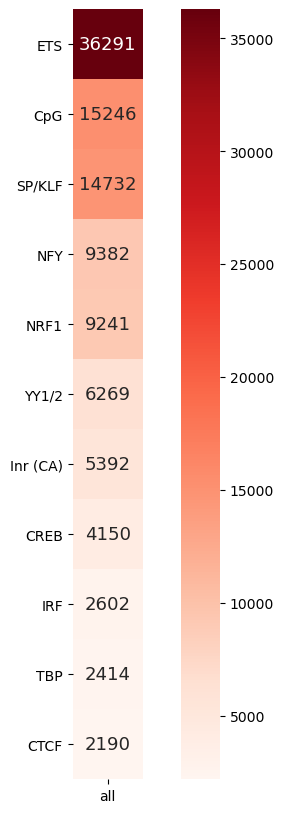

In [8]:
# Plot motif frequency

fig = plt.figure(figsize=(10, 10))
sns.heatmap(
    pd.DataFrame(grouped_counts["all"]).iloc[:11],
    annot=True,
    annot_kws={"size": 13},
    cmap="Reds",
    fmt="g",
    square=True,
    #cbar=False,
    #norm=colors.TwoSlopeNorm(0)
)
plt.yticks(rotation=0) 
plt.savefig("img/modisco_quantity_frequency_plot.pdf")

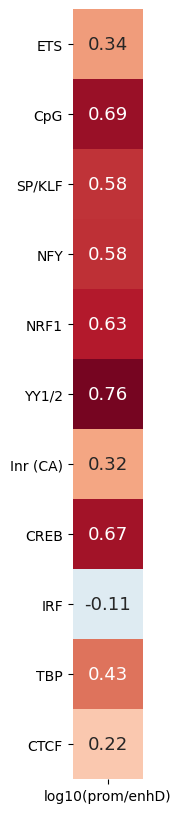

In [9]:
# Plot log10(prom/enhD)

fig = plt.figure(figsize=(10, 10))
sns.heatmap(
    pd.DataFrame(np.log10(grouped_frequency.prom / grouped_frequency.enhD), columns=["log10(prom/enhD)"])[:11],
    annot=True,
    annot_kws={"size": 13},
    fmt=".2",
    square=True,
    cbar=False,
    cmap="RdBu_r",
    norm=colors.Normalize(-0.8, 0.8)
)
plt.yticks(rotation=0) 
plt.savefig("img/modisco_quantity_prom2enh_plot.pdf")